# Tarea 1: Perceptrón Multicapa
### EL4106 Inteligencia Computacional

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Juan Urrutia<br>

## Imports

In [1]:
from pathlib import Path
import time

import torch
from torch import nn
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Preparación de la base de datos MNIST

Cargamos los datos de MNIST desde la librería `torchvision`.

La clase torchvision.datasets.MNIST retorna un dataset de pytorch con los ejemplos de las imágenes y sus respectivas clases (un dataset como los que ya hemos visto en la actividad 2). Sin embargo, cada ejemplo es entregado como una imagen PIL. Por esto es necesario definir una transformación que toma la imagen PIL y la pasa a un tensor de pytorch. Además, cada pixel de las imágenes de MNIST tienen valores entre 0 y 255 para la escala de grises (donde 0 es color negro y 255 es color blanco). La transformación ToTensor toma estos valores y los normaliza entre 0 y 1 (básicamente los divide por 255). Por lo tanto, el tensor final entregado es de la forma de la imagen original, donde cada elemento corresponde a un pixel con un valor entre 0 y 1.

Los tensores obtenidos por la transformación ToTensor son de la forma 1x28x28, donde la primera dimensión representa los canales de color. En este caso es escala de grises, por lo que se tiene sólo un canal, pero si la imagen fuese RGB, existirían 3 canales de color y el tensor sería de la forma 3x28x28. Las últimas dos dimensiones representan los pixeles de cada dimensión. En este caso tenemos una imagen de 28x28. Dado que utilizaremos MLP, tenemos que entregar cada dato en forma de vector, por lo que utilizamos la segunda transformación que "aplana" estos tensores, pasando de la forma 1x28x28 a 784. Esta última transformación la hace el objeto `torchvision.transforms.Lambda` que toma una función definida por nosotros y la aplica a cada tensor. En este caso es la función `flatten`, que como su nombre lo dice, aplana los tensores.

La forma de juntar estas dos transformaciones anteriores es utilizando el objeto `torchvision.transforms.Compose` que compone transformaciones (como su nombre lo dice).

Además se define la variable `target_transform` que transforma los labels del dataset. En este caso la transformación toma cada label (números del 0 al 9) y los transforma en un 1 (si el dígito es igual a 8) ó en 0 (si el dígito es distinto a 8). De esta forma pasamos de una tarea de clasificación de 10 dígitos a una tarea de clasificación en la cual queremos identificar si un dígito es un 8 o no. Además podemos cambiar el dígito escogido alterando la variable `chosen_digit`. Para la tarea no cambien esta variable.

Puede cambiar la variable `indice_de_ejemplo` al índice que desee para observar distintas instancias del dataset de entrenamiento.

Para mostrar esta imagen con matplotlib utilizamos la función x.reshape(28, 28), esta toma el tensor y lo transforma nuevamente en un tensor de 28x28. Esto es necesario para mostrar la imagen en matplotlib (pueden revisar la [documentación](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) para ver qué recibe la función imshow).

In [2]:
# Dígito escogido para clasificar
chosen_digit = 8

# Se define una transformación para las imágenes (La primera transforma las imágenes a tensor y la segunda aplana los tensores en vectores)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t: t.flatten()),
])

# Se define una transformación para los labels. Esta toma cada label y los transforma a 1 y 0,
# donde 1 representa que el dígito es igual al dígito escogido (en este caso 8) y 0 representa que es otro dígito.
target_transform = torchvision.transforms.Lambda(lambda label: 1 if label == chosen_digit else 0)

# Se descargan los datasets de train y test de mnist y se transforman
root_dataset_dir = "./mnist"

train_mnist_dataset = torchvision.datasets.MNIST(
    root=root_dataset_dir,
    train=True,
    transform=transform, # Acá definimos la transformación a las imágenes
    target_transform=target_transform, # Acá definimos la transformación a los labels
    download=True
)
test_mnist_dataset = torchvision.datasets.MNIST(
    root=root_dataset_dir,
    train=False,
    transform=transform, # Acá definimos la transformación a las imágenes
    target_transform=target_transform, # Acá definimos la transformación a los labels
    download=True
)

# Del dataset de entrenamieno obtenemos una porción que utilizaremos como dataset de validación
# Sabemos que son 60000 datos totales del dataset original de entrenamiento y 10000 de test.
# Por lo tanto tomamos 10000 datos del dataset de entrenamiento y los utilizamos como validación (eliminándolos del dataset de entrenamiento)
train_size = 55000
val_size = len(train_mnist_dataset) - train_size
train_mnist_dataset, val_mnist_dataset = torch.utils.data.random_split(train_mnist_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"El dataset de entrenamiento completo tiene: {len(train_mnist_dataset)} elementos.")
print(f"El dataset de validación tiene: {len(val_mnist_dataset)} elementos.")
print(f"El dataset de test tiene: {len(test_mnist_dataset)} elementos.")

print()

x, y = train_mnist_dataset[0]
print(f"Primer ejemplo obtenido del dataset:")
print(f"Tensor de tamaño: {x.shape} con valor mínimo: {x.min()} y máximo: {x.max()}")
print("Clase:", y)

El dataset de entrenamiento completo tiene: 55000 elementos.
El dataset de validación tiene: 5000 elementos.
El dataset de test tiene: 10000 elementos.

Primer ejemplo obtenido del dataset:
Tensor de tamaño: torch.Size([784]) con valor mínimo: 0.0 y máximo: 1.0
Clase: 0


Los datasets anteriores están desbalanceados ya que hay muchos menos 8 que otros números. A continuación los balanceamos muestreando la misma cantidad de dígitos que no son 8 de forma aleatoria.

In [3]:
def balance_dataset(dataset):
    data_tuples = [(x, y) for (x, y) in dataset] # Separamos el dataset en X, y
    X = torch.stack([t[0] for t in data_tuples])
    y = torch.tensor([t[1] for t in data_tuples])

    # Observamos el desbalance
    unique_elements, counts = np.unique(y, return_counts=True)
    if counts[0] == counts[1]:
        print("Dataset ya fue balanceado. Retornando dataset original.")
        return dataset

    print(f"Dataset desbalanceado con {counts[0]} elementos con etiqueta {unique_elements[0]} y {counts[1]} elementos con etiqueta {unique_elements[1]}")

    min_class = unique_elements[np.argmin(counts)]

    other_class_indices = np.random.choice(np.where(y != min_class)[0], size=min(counts), replace=False)
    min_class_indices = np.where(y == min_class)[0]

    total_indices = np.concatenate((other_class_indices, min_class_indices))

    final_X = X[total_indices]
    final_y = y[total_indices]

    # Observamos el dataset balanceado
    unique_elements, counts = np.unique(final_y, return_counts=True)
    print(f"Dataset balanceado con {counts[0]} elementos con etiqueta {unique_elements[0]} y {counts[1]} elementos con etiqueta {unique_elements[1]}")

    final_dataset = torch.utils.data.TensorDataset(
        final_X.float(),
        final_y,
    )

    return final_dataset

In [4]:
print("Balanceando dataset de entrenamiento.")
train_mnist_dataset = balance_dataset(train_mnist_dataset)
print()

print("Balanceando dataset de validación.")
val_mnist_dataset = balance_dataset(val_mnist_dataset)
print()

print("Balanceando dataset de test.")
test_mnist_dataset = balance_dataset(test_mnist_dataset)

Balanceando dataset de entrenamiento.
Dataset desbalanceado con 49653 elementos con etiqueta 0 y 5347 elementos con etiqueta 1
Dataset balanceado con 5347 elementos con etiqueta 0 y 5347 elementos con etiqueta 1

Balanceando dataset de validación.
Dataset desbalanceado con 4496 elementos con etiqueta 0 y 504 elementos con etiqueta 1
Dataset balanceado con 504 elementos con etiqueta 0 y 504 elementos con etiqueta 1

Balanceando dataset de test.
Dataset desbalanceado con 9026 elementos con etiqueta 0 y 974 elementos con etiqueta 1
Dataset balanceado con 974 elementos con etiqueta 0 y 974 elementos con etiqueta 1


Observamos algunos ejemplos y sus respectivas clases

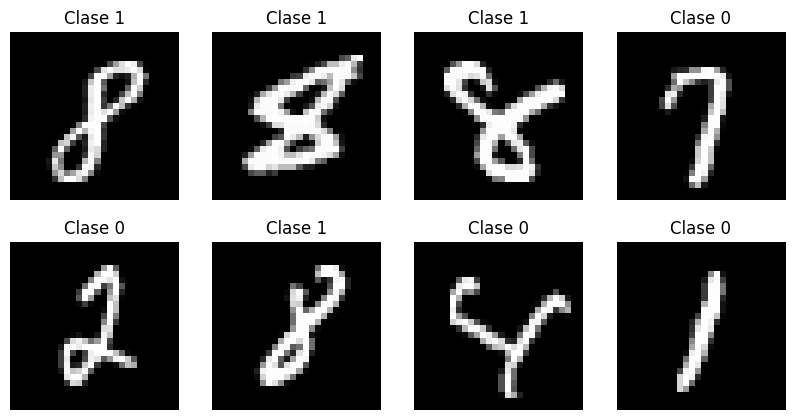

In [5]:
chosen_indices = np.random.RandomState(seed=2).choice(len(train_mnist_dataset), size=8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ax in zip(chosen_indices, axes.flat):
    x, y = train_mnist_dataset[idx]
    ax.imshow(x.reshape(28, 28), cmap="gray")
    ax.set_title(f"Clase {y}")
    ax.axis('off')

plt.show()

## Definición de Clasificador MLP

### Función de costo

Definimos nuestras funciones de costo

In [6]:
mse_criterion = nn.MSELoss()
cross_entropy_criterion = nn.BCELoss()

### Clase de Clasificador MLP
Se define el modelo MLP. Este toma como entrada el número de features y una lista con los tamaños de cada capa.

Notemos que la última capa corresponde a una nn.Linear que termina en un valor. Para una clasificación multi-clase, se pondría al final una capa lineal que termine en el número de clases, otorgando una probabilidad para cada clase en cada una de las neuronas de salida. Dado que tenemos una clasificación binaria, tenemos dos formas de definir esto, podemos utilizar dos neuronas de salida, tal que la primera defina la probabilidad de que la clase sea 0 y la segunda la probabilidad de que la clase sea 1. O bien, podemos definirlo como lo hacemos en este caso, donde tenemos una sola salida, tal que esta representa la probabilidad de que la clase sea 1.

Esto último podemos hacerlo ya que sabemos que la probabilidad de que la clase sea 0 es equivalente a $1 - P(C = 1)$.

Si utilizamos esta formulación, entonces podemos usar la función de costo BCELoss (Binary Cross Entropy Loss). Si utilizamos la primera formulación tenemos que usar la función de costo CrossEntropyLoss.

In [7]:
class MLPClassifier(nn.Module):
    def __init__(self, n_features, layer_sizes):
        super().__init__()
        
        """
        Acá definimos las capas ocultas.
        Ejemplo:
        Si recibimos layer_sizes = [10, 20], entonces se creará una red:

        self.net = nn.Sequential(
            nn.Linear(n_features, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

        Las dos primeras capas (y sus respectivas funciones de activación) se
        definirán en el loop for que se tiene acá abajo. La última capa (y la
        función sigmoide final) se agrega en el append que viene luego del loop for.
        """
        
        layers = []
        prev_size = n_features
        for layer_size in layer_sizes:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size

        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

### Función de entrenamiento

In [8]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [9]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    criterion,
    batch_size,
    lr,
    early_stopping_tolerance=15,
    use_gpu=False
):
    if use_gpu:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i}/{len(train_loader)}", end="")
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            y_predicted = model(x_batch)

            y_batch = y_batch.reshape(-1, 1).float()

            # Cálculo de loss
            loss = criterion(y_predicted, y_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

            # Calculamos número de aciertos
            class_prediction = (y_predicted > 0.5)
            cumulative_train_corrects += (y_batch == class_prediction).sum()

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects / len(train_dataset)

        # Evaluación del modelo
        model.eval()
        x_val, y_val = next(iter(val_loader))
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        y_val = y_val.reshape(-1, 1).float()
        loss = criterion(y_predicted, y_val)

        class_prediction = (y_predicted > 0.5).long()
        val_acc = (y_val == class_prediction).sum() / y_val.shape[0]
        val_loss = loss.item()

        curves["train_acc"].append(train_acc.item())
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

## Entrenamiento de MLP

# Pregunta 1

Funcion de costo de entropia cruzada

In [34]:


epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.3179522820595485, Train acc: 0.8677763342857361, Val loss: 0.21948744356632233, Val acc: 0.9236111044883728
Epoch 2/100 - Batch 334/335 - Train loss: 0.17249568478385013, Train acc: 0.9394052624702454, Val loss: 0.1560726761817932, Val acc: 0.9523809552192688
Epoch 3/100 - Batch 334/335 - Train loss: 0.12089835027260566, Train acc: 0.9571722745895386, Val loss: 0.11364119499921799, Val acc: 0.9652777910232544
Epoch 4/100 - Batch 334/335 - Train loss: 0.09461829416287035, Train acc: 0.9679259657859802, Val loss: 0.11249799281358719, Val acc: 0.9682539701461792
Epoch 5/100 - Batch 334/335 - Train loss: 0.07819635861400348, Train acc: 0.9735365509986877, Val loss: 0.08943848311901093, Val acc: 0.976190447807312
Epoch 6/100 - Batch 334/335 - Train loss: 0.06626177831177614, Train acc: 0.9781185984611511, Val loss: 0.08731609582901001, Val acc: 0.976190447807312
Epoch 7/100 - Batch 334/335 - Train loss: 0.056692486222

### Tasa de acierto en validación computada sobre varias ejecuciones.

In [35]:
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Final validation accuracy 0.979 +/- 0.002
[0.98214287 0.97817463 0.97817463 0.97619045 0.97916669]
Final train accuracy 0.999 +/- 0.001
[0.99981296 0.99990648 1.         0.99719471 0.9992519 ]


## Visualización de Resultados

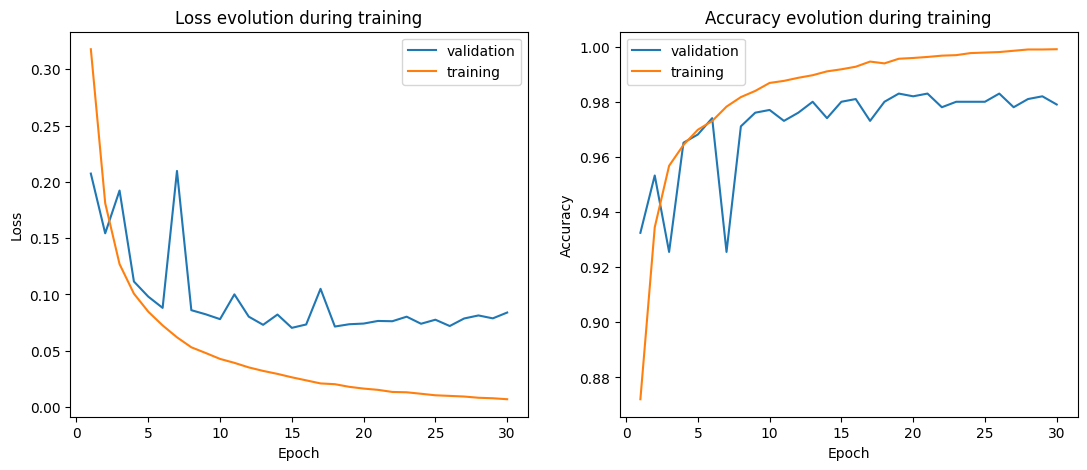

In [ ]:
# Obtenemos las curvas del último entrenamiento y las mostramos
last_curves = curves_history[-1]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(last_curves["val_loss"])) + 1

ax[0].plot(epochs, last_curves['val_loss'], label='validation')
ax[0].plot(epochs, last_curves['train_loss'], label='training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(epochs, last_curves['val_acc'], label='validation')
ax[1].plot(epochs, last_curves['train_acc'], label='training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

plt.show()

Funcion de costo MSE

In [37]:


epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

#criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.12601352255068607, Train acc: 0.837572455406189, Val loss: 0.07244429737329483, Val acc: 0.9246031641960144
Epoch 2/100 - Batch 334/335 - Train loss: 0.0764703544885365, Train acc: 0.9014400839805603, Val loss: 0.059478551149368286, Val acc: 0.9365079402923584
Epoch 3/100 - Batch 334/335 - Train loss: 0.061456066411711384, Train acc: 0.9247241616249084, Val loss: 0.05523185059428215, Val acc: 0.9355158805847168
Epoch 4/100 - Batch 334/335 - Train loss: 0.05050931747780362, Train acc: 0.9406208992004395, Val loss: 0.04715567082166672, Val acc: 0.9434523582458496
Epoch 5/100 - Batch 334/335 - Train loss: 0.04370088533275941, Train acc: 0.9485692977905273, Val loss: 0.0417715385556221, Val acc: 0.9523809552192688
Epoch 6/100 - Batch 334/335 - Train loss: 0.0378125077808526, Train acc: 0.9569852352142334, Val loss: 0.037912219762802124, Val acc: 0.9573412537574768
Epoch 7/100 - Batch 334/335 - Train loss: 0.033378969

### Tasa de acierto en validación computada sobre varias ejecuciones.

In [ ]:
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Final validation accuracy 0.979 +/- 0.002
[0.98214287 0.97817463 0.97817463 0.97619045 0.97916669]
Final train accuracy 0.999 +/- 0.001
[0.99981296 0.99990648 1.         0.99719471 0.9992519 ]


## Visualización de Resultados

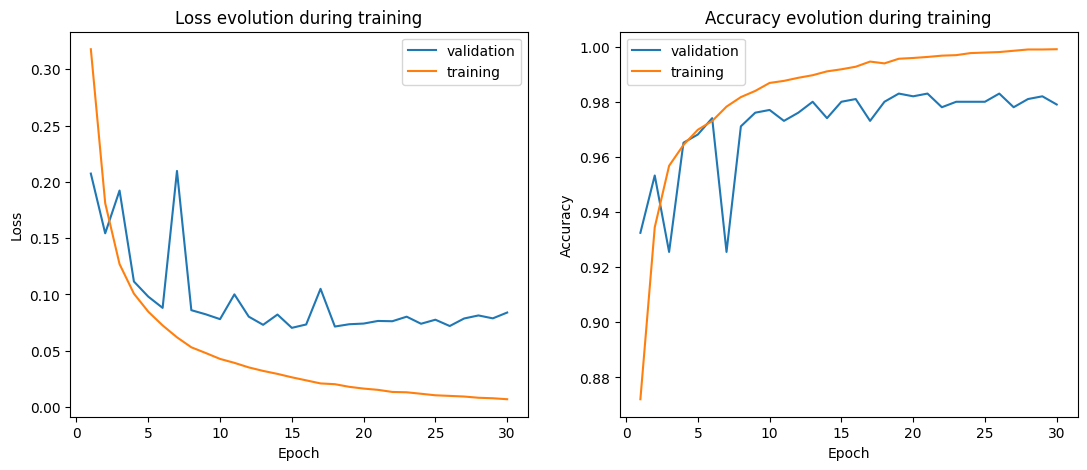

In [ ]:
# Obtenemos las curvas del último entrenamiento y las mostramos
last_curves = curves_history[-1]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(last_curves["val_loss"])) + 1

ax[0].plot(epochs, last_curves['val_loss'], label='validation')
ax[0].plot(epochs, last_curves['train_loss'], label='training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(epochs, last_curves['val_acc'], label='validation')
ax[1].plot(epochs, last_curves['train_acc'], label='training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

plt.show()

# Pregunta 2

tasa de aprendizaje de 1e-2

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.5418415626483177, Train acc: 0.7853936553001404, Val loss: 0.4084838628768921, Val acc: 0.8670634627342224
Epoch 2/100 - Batch 334/335 - Train loss: 0.37100963129926084, Train acc: 0.85739666223526, Val loss: 0.3085503578186035, Val acc: 0.8908730149269104
Epoch 3/100 - Batch 334/335 - Train loss: 0.315255743843406, Train acc: 0.8759117126464844, Val loss: 0.2751099169254303, Val acc: 0.903769850730896
Epoch 4/100 - Batch 334/335 - Train loss: 0.2910047582948386, Train acc: 0.8861978650093079, Val loss: 0.2553563714027405, Val acc: 0.9146825671195984
Epoch 5/100 - Batch 334/335 - Train loss: 0.27252467251313267, Train acc: 0.8929306268692017, Val loss: 0.24298079311847687, Val acc: 0.9226190447807312
Epoch 6/100 - Batch 334/335 - Train loss: 0.2592793030970132, Train acc: 0.9001309275627136, Val loss: 0.2321094572544098, Val acc: 0.9285714030265808
Epoch 7/100 - Batch 334/335 - Train loss: 0.24729282375591904, Tr

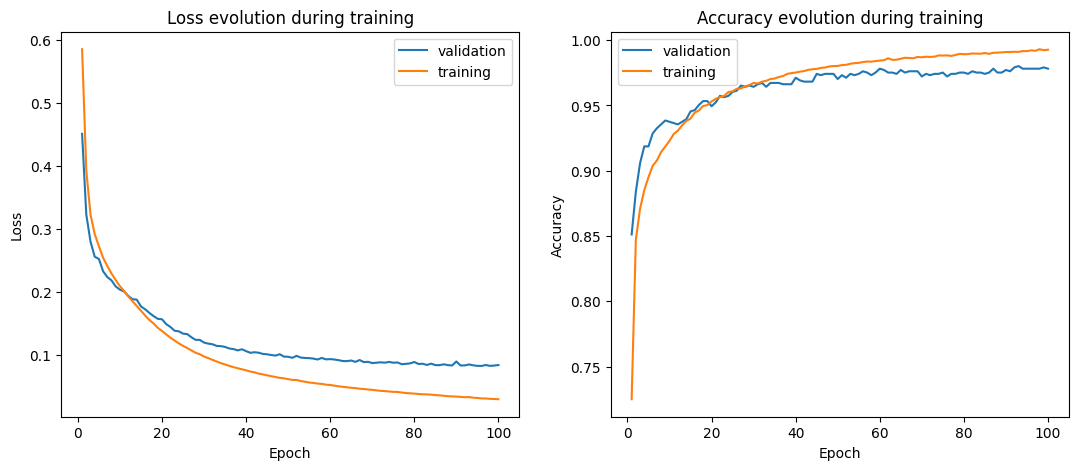

In [39]:
epochs = 100
lr = 1e-2
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)
# Obtenemos las curvas del último entrenamiento y las mostramos
last_curves = curves_history[-1]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(last_curves["val_loss"])) + 1

ax[0].plot(epochs, last_curves['val_loss'], label='validation')
ax[0].plot(epochs, last_curves['train_loss'], label='training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(epochs, last_curves['val_acc'], label='validation')
ax[1].plot(epochs, last_curves['train_acc'], label='training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

plt.show()

tasa de aprendizaje de 1e-0

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.42638254757247757, Train acc: 0.8054049015045166, Val loss: 0.25297725200653076, Val acc: 0.9117063283920288
Epoch 2/100 - Batch 334/335 - Train loss: 0.18682890800731394, Train acc: 0.9340751767158508, Val loss: 0.14282475411891937, Val acc: 0.954365074634552
Epoch 3/100 - Batch 334/335 - Train loss: 0.12157723558093629, Train acc: 0.9600710868835449, Val loss: 0.11441070586442947, Val acc: 0.9692460298538208
Epoch 4/100 - Batch 334/335 - Train loss: 0.09311171232847802, Train acc: 0.9683935046195984, Val loss: 0.09711255133152008, Val acc: 0.9692460298538208
Epoch 5/100 - Batch 334/335 - Train loss: 0.07845029833712684, Train acc: 0.9722273945808411, Val loss: 0.08710119873285294, Val acc: 0.9771825671195984
Epoch 6/100 - Batch 334/335 - Train loss: 0.06988032476093843, Train acc: 0.9775574803352356, Val loss: 0.0788692757487297, Val acc: 0.9742063283920288
Epoch 7/100 - Batch 334/335 - Train loss: 0.0556796826

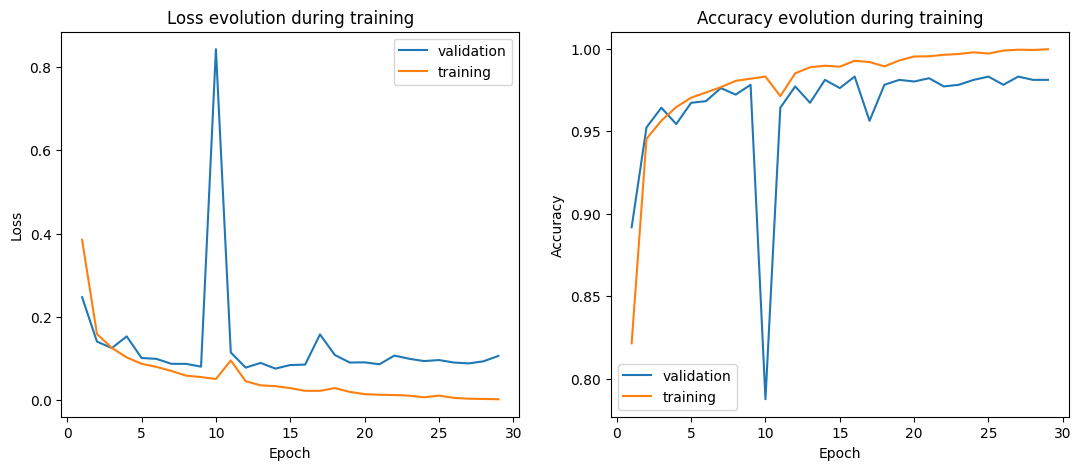

In [40]:
epochs = 100
lr = 1e-0
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)
# Obtenemos las curvas del último entrenamiento y las mostramos
last_curves = curves_history[-1]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(last_curves["val_loss"])) + 1

ax[0].plot(epochs, last_curves['val_loss'], label='validation')
ax[0].plot(epochs, last_curves['train_loss'], label='training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(epochs, last_curves['val_acc'], label='validation')
ax[1].plot(epochs, last_curves['train_acc'], label='training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

plt.show()

tasa de aprendizaje de 1e1

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 49.61756370797086, Train acc: 0.5001870393753052, Val loss: 50.0, Val acc: 0.5
Epoch 2/100 - Batch 334/335 - Train loss: 50.080845778735714, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 3/100 - Batch 334/335 - Train loss: 49.95957711063214, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 4/100 - Batch 334/335 - Train loss: 50.0, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 5/100 - Batch 334/335 - Train loss: 50.0, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 6/100 - Batch 334/335 - Train loss: 50.080845778735714, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 7/100 - Batch 334/335 - Train loss: 49.95957711063214, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 8/100 - Batch 334/335 - Train loss: 50.0, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 9/100 - Batch 334/335 - Train loss: 50.0, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 10/100 - Batch 334/335 - Train loss: 49.91915

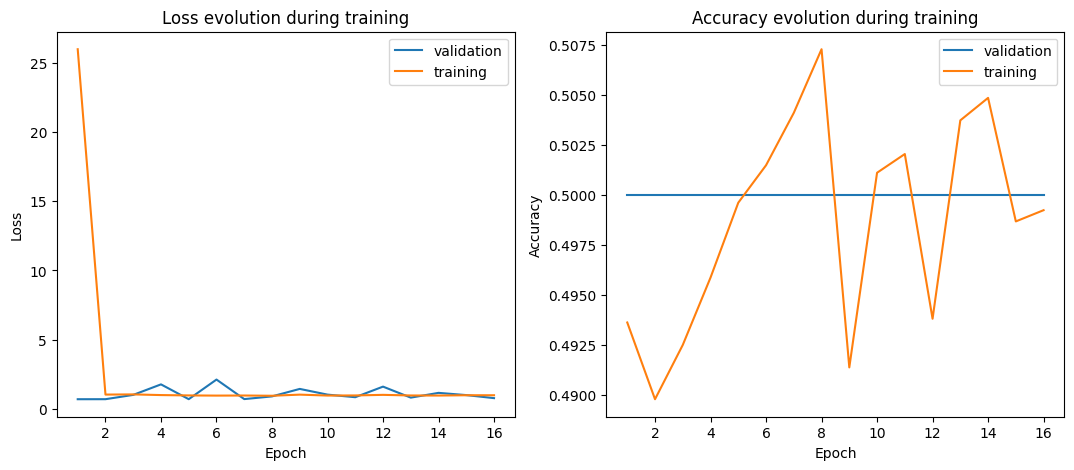

In [41]:
epochs = 100
lr = 1e1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)
# Obtenemos las curvas del último entrenamiento y las mostramos
last_curves = curves_history[-1]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(last_curves["val_loss"])) + 1

ax[0].plot(epochs, last_curves['val_loss'], label='validation')
ax[0].plot(epochs, last_curves['train_loss'], label='training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(epochs, last_curves['val_acc'], label='validation')
ax[1].plot(epochs, last_curves['train_acc'], label='training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

plt.show()

# Parte 3:
utilizando 1 neuronas en la capa oculta

In [42]:
epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[1],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.4920819617029446, Train acc: 0.7622966170310974, Val loss: 0.37860724329948425, Val acc: 0.846230149269104
Epoch 2/100 - Batch 334/335 - Train loss: 0.32951278877792073, Train acc: 0.8775014281272888, Val loss: 0.5199198722839355, Val acc: 0.7539682388305664
Epoch 3/100 - Batch 334/335 - Train loss: 0.29453183710575104, Train acc: 0.8914344310760498, Val loss: 0.28852739930152893, Val acc: 0.898809552192688
Epoch 4/100 - Batch 334/335 - Train loss: 0.2740173942339954, Train acc: 0.8962034583091736, Val loss: 0.2396707683801651, Val acc: 0.9186508059501648
Epoch 5/100 - Batch 334/335 - Train loss: 0.2632520008665412, Train acc: 0.902281641960144, Val loss: 0.3336814343929291, Val acc: 0.858134925365448
Epoch 6/100 - Batch 334/335 - Train loss: 0.2597427795960832, Train acc: 0.9016270637512207, Val loss: 0.2800266146659851, Val acc: 0.8948412537574768
Epoch 7/100 - Batch 334/335 - Train loss: 0.2524091251528085, Tr

Utilizando 10 neuronas en la capa oculta

In [43]:
epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[10],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.32885177911662344, Train acc: 0.8575837016105652, Val loss: 0.22029419243335724, Val acc: 0.9246031641960144
Epoch 2/100 - Batch 334/335 - Train loss: 0.20011643097916645, Train acc: 0.9272488951683044, Val loss: 0.17517970502376556, Val acc: 0.9414682388305664
Epoch 3/100 - Batch 334/335 - Train loss: 0.15233924803671553, Train acc: 0.9461380243301392, Val loss: 0.1422252357006073, Val acc: 0.9513888955116272
Epoch 4/100 - Batch 334/335 - Train loss: 0.12390414971107645, Train acc: 0.955395519733429, Val loss: 0.12947866320610046, Val acc: 0.9523809552192688
Epoch 5/100 - Batch 334/335 - Train loss: 0.10677350368072737, Train acc: 0.9626893401145935, Val loss: 0.18636879324913025, Val acc: 0.9375
Epoch 6/100 - Batch 334/335 - Train loss: 0.09369107951590819, Train acc: 0.9672713875770569, Val loss: 0.10449474304914474, Val acc: 0.9623016119003296
Epoch 7/100 - Batch 334/335 - Train loss: 0.0823877453387006, Trai

Utilizando 25 neuronas en la capa oculta

In [57]:
epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.3220127419304492, Train acc: 0.8649709820747375, Val loss: 0.22552667558193207, Val acc: 0.9196428656578064
Epoch 2/100 - Batch 334/335 - Train loss: 0.17950798574445853, Train acc: 0.9354778528213501, Val loss: 0.15911369025707245, Val acc: 0.9444444179534912
Epoch 3/100 - Batch 334/335 - Train loss: 0.12976361155621152, Train acc: 0.952870786190033, Val loss: 0.1270214021205902, Val acc: 0.9583333134651184
Epoch 4/100 - Batch 334/335 - Train loss: 0.10736082034435734, Train acc: 0.9624088406562805, Val loss: 0.11457111686468124, Val acc: 0.9623016119003296
Epoch 5/100 - Batch 334/335 - Train loss: 0.09180322893297495, Train acc: 0.9678324460983276, Val loss: 0.11211492121219635, Val acc: 0.966269850730896
Epoch 6/100 - Batch 334/335 - Train loss: 0.08079348081695055, Train acc: 0.9716663360595703, Val loss: 0.11778537184000015, Val acc: 0.9652777910232544
Epoch 7/100 - Batch 334/335 - Train loss: 0.068345788441

Utilizando 100 neuronas en la capa oculta

In [55]:
epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[100],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.3036892381621831, Train acc: 0.8724518418312073, Val loss: 0.20529277622699738, Val acc: 0.9295634627342224
Epoch 2/100 - Batch 334/335 - Train loss: 0.1621956201492628, Train acc: 0.9427716732025146, Val loss: 0.13681890070438385, Val acc: 0.9603174328804016
Epoch 3/100 - Batch 334/335 - Train loss: 0.11175006525174006, Train acc: 0.9611932039260864, Val loss: 0.1170506626367569, Val acc: 0.9682539701461792
Epoch 4/100 - Batch 334/335 - Train loss: 0.08627720011481599, Train acc: 0.9704506993293762, Val loss: 0.10308191180229187, Val acc: 0.9692460298538208
Epoch 5/100 - Batch 334/335 - Train loss: 0.0700689058180954, Train acc: 0.9750327467918396, Val loss: 0.12449347972869873, Val acc: 0.961309552192688
Epoch 6/100 - Batch 334/335 - Train loss: 0.05963545820133677, Train acc: 0.9810174107551575, Val loss: 0.10325110703706741, Val acc: 0.9702380895614624
Epoch 7/100 - Batch 334/335 - Train loss: 0.0505116636343

Aumentando criterio de early stopping a 100

In [70]:
epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 100
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
#criterion = nn.MSELoss()

run_n_times = 1
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Entrenando corrida número 1/1
Epoch 1/100 - Batch 334/335 - Train loss: 0.3158138469528796, Train acc: 0.8713297247886658, Val loss: 0.5862361192703247, Val acc: 0.7480158805847168
Epoch 2/100 - Batch 334/335 - Train loss: 0.19165900921198858, Train acc: 0.9286515712738037, Val loss: 0.1972852200269699, Val acc: 0.9434523582458496
Epoch 3/100 - Batch 334/335 - Train loss: 0.14095432861749804, Train acc: 0.9525902271270752, Val loss: 0.1342606395483017, Val acc: 0.95932537317276
Epoch 4/100 - Batch 334/335 - Train loss: 0.10931865709708698, Train acc: 0.9608191251754761, Val loss: 0.14833728969097137, Val acc: 0.949404776096344
Epoch 5/100 - Batch 334/335 - Train loss: 0.09213004991578967, Train acc: 0.968767523765564, Val loss: 0.10461465269327164, Val acc: 0.9732142686843872
Epoch 6/100 - Batch 334/335 - Train loss: 0.07324777957010291, Train acc: 0.9768094420433044, Val loss: 0.10485421866178513, Val acc: 0.9692460298538208
Epoch 7/100 - Batch 334/335 - Train loss: 0.0651762083867815

### Tasa de acierto en validación computada sobre varias ejecuciones.

In [61]:
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Final validation accuracy 0.980 +/- 0.000
[0.98015875]
Final train accuracy 1.000 +/- 0.000
[1.]


## Visualización de Resultados

### Algunas estadísticas del entrenamiento

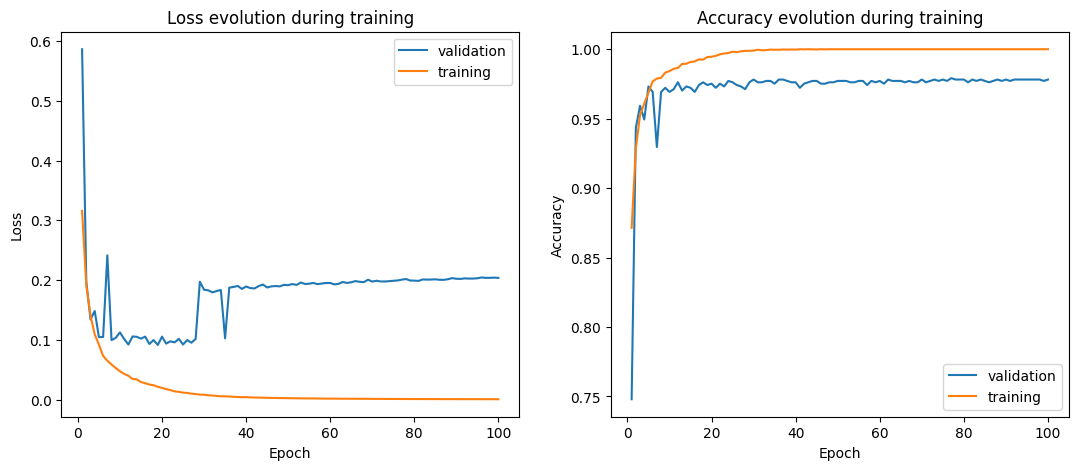

In [71]:
# Obtenemos las curvas del último entrenamiento y las mostramos
last_curves = curves_history[-1]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(last_curves["val_loss"])) + 1

ax[0].plot(epochs, last_curves['val_loss'], label='validation')
ax[0].plot(epochs, last_curves['train_loss'], label='training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(epochs, last_curves['val_acc'], label='validation')
ax[1].plot(epochs, last_curves['train_acc'], label='training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

plt.show()

### Estadísticas del desempeño final

In [48]:
def performance_metrics(TP, FP, FN, TN):
    """Calcula metricas de desempeño.
    
    Args:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.
    
    Returns:
        accuracy: Porcentaje de clasificaciones correctas del detector.
        precision: Precision del detector.
        recall: Recall/Sensibilidad del detector.
    """
    accuracy = 100.0 * (TP + TN) / (TP + TN + FP + FN)
    precision = 100.0 * TP / (TP + FP)
    recall = 100.0 * TP / (TP + FN)
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    print(f"{accuracy:.4f} Accuracy (Porcentaje de clasificaciones correctas)")
    print(f"{precision:.4f} Precision")
    print(f"{recall:.4f} Recall")
    print()
    return accuracy, precision, recall

def roc_curve(labels, probabilities):
    """Calcula la curva ROC.
    
    Args:
        labels: Array binario 1-D con las etiquetas reales.
        probabilities: Array 1-D continuo en el rango [0, 1] con las
            probabilidades de la clase 1.
        
    Returns:
        tpr: Array 1-D con los valores de Tasa de Verdaderos Positivos (TPR).
        fpr: Array 1-D con los valores de Tasa de Falsos Positivos (FPR).
    """
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        TN, FP, FN, TP = conf_matrix_given_threshold(labels, probabilities, threshold)
        tpr.append(TP / (TP + FN))
        fpr.append(FP / (FP + TN))

    return np.array(tpr), np.array(fpr)

def conf_matrix_given_threshold(true_labels, prediction, threshold):
    probabilities_with_threshold = (prediction > threshold).long()
    TN, FP, FN, TP = confusion_matrix(true_labels, probabilities_with_threshold).ravel()   
    return TN, FP, FN, TP

In [63]:
X_train, y_train = train_mnist_dataset[:]
X_val, y_val = val_mnist_dataset[:]
X_test, y_test = test_mnist_dataset[:]

train_probabilities = model(X_train).reshape(-1)
val_probabilities = model(X_val).reshape(-1)
test_probabilities = model(X_test).reshape(-1)

train_predicted_labels = (train_probabilities > 0.5).long()
val_predicted_labels = (val_probabilities > 0.5).long()
test_predicted_labels = (test_probabilities > 0.5).long()

TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()

print('Training results:')
TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TN, FP, FN, TP = confusion_matrix(y_val, val_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TN, FP, FN, TP = confusion_matrix(y_test, test_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

Training results:
TP: 5347, TN: 5347, FP: 0, FN: 0
100.0000 Accuracy (Porcentaje de clasificaciones correctas)
100.0000 Precision
100.0000 Recall

Validation results:
TP: 493, TN: 495, FP: 9, FN: 11
98.0159 Accuracy (Porcentaje de clasificaciones correctas)
98.2072 Precision
97.8175 Recall

Test results:
TP: 952, TN: 956, FP: 18, FN: 22
97.9466 Accuracy (Porcentaje de clasificaciones correctas)
98.1443 Precision
97.7413 Recall



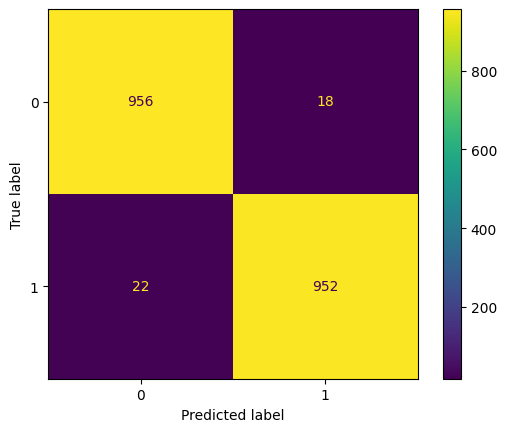

In [64]:
# Graficamos la matriz de confusión de los datos de test
ConfusionMatrixDisplay.from_predictions(y_test, test_predicted_labels)
plt.show()

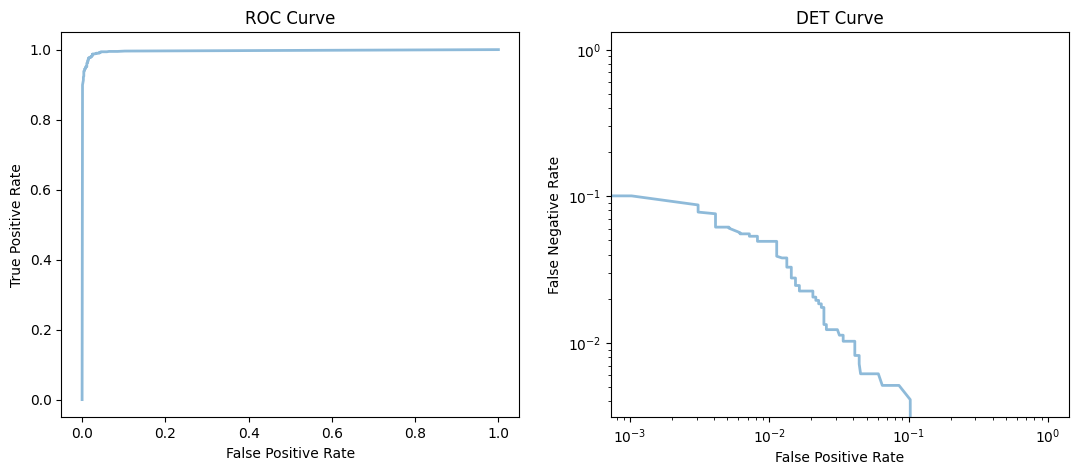

In [65]:
# Graficamos la curva ROC en test
tpr, fpr = roc_curve(y_test, test_probabilities)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

ax[0].set_title('ROC Curve')
ax[0].plot(fpr, tpr, linewidth=2, alpha=0.5)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].set_title('DET Curve')
ax[1].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('False Negative Rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

### Performance según umbral de clasificación

In [75]:
threshold = 0.1
TN, FP, FN, TP = conf_matrix_given_threshold(y_val, val_probabilities, threshold=threshold)
print(f"Threshold: {threshold} | TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Threshold: 0.1 | TP: 499, TN: 484, FP: 20, FN: 5


### Visualización de clasificaciones en el test

True Positives:


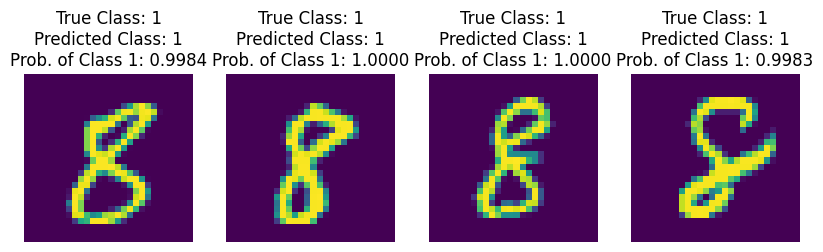

True Negatives:


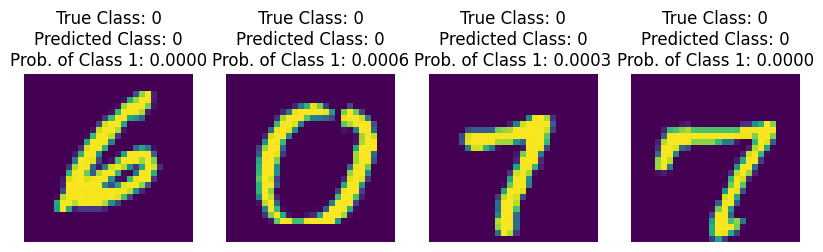

False Positive:


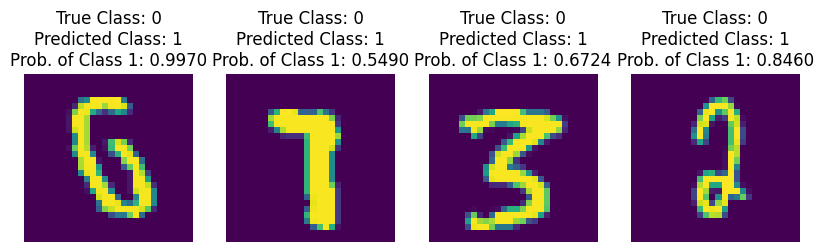

False Negative:


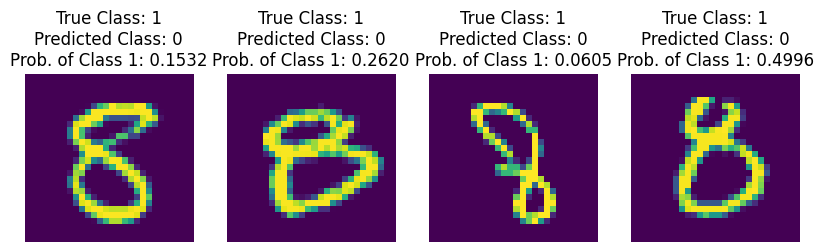

In [30]:
def show_classifications(images, labels, probabilities, result_type='TP'):
    """ Muestra ejemplos de imagenes para tipos de errores.
    
    Args:
        images: Array de dimensiones (n_ejemplos, n_pixeles) con imagenes.
        labels: Array de dimensiones (n_ejemplos,) con las etiquetas reales.
        probabilities: Array de dimensiones (n_ejemplos,) con las probabilidades
            de la clase 1.
        result_type: 'TP', 'FP', 'FN', o 'TP', tipo de error a mostrar.
    """
    dict_types = {'TN': 0, 'FP': 1, 'FN': 2, 'TP': 3}
    predictions = (probabilities > 0.5).long()
    encoded_data = 2 * labels + predictions 
    useful = np.where(encoded_data == dict_types[result_type])[0]
    size = min(4, useful.shape[0])
    chosen = np.random.choice(useful, size=size, replace=False)
    fig, ax = plt.subplots(1, 4, figsize=(10,4))
    fig.set_facecolor('white')
    for i, idx in enumerate(chosen):
        image = images[idx, :]
        digit = labels[idx]
        predicted_label = predictions[idx]
        proba = probabilities[idx]
        ax[i].imshow(image.reshape((28, 28)))
        ax[i].set_title("True Class: %d\nPredicted Class: %d\nProb. of Class 1: %1.4f"
                        % (digit, predicted_label, proba))
        ax[i].axis('off')
    for j in range(i+1, 4):
        ax[j].axis('off')

    plt.show()


test_probabilities = model(X_test).reshape(-1)

print('True Positives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TP')

print('True Negatives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TN')

print('False Positive:')
show_classifications(X_test, y_test, test_probabilities , result_type='FP')

print('False Negative:')
show_classifications(X_test, y_test, test_probabilities , result_type='FN')